# Anycost-GAN

### Adjust one's face apperance with various properties.

Original Author: [MIT HAN Lab](https://github.com/mit-han-lab)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/mit-han-lab/anycost-gan

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/AnycostGAN.ipynb)

In [ ]:
#@title Setup

!pip install torchvision==0.8.2 lpips
!git clone https://github.com/mit-han-lab/anycost-gan.git
%cd anycost-gan

from PIL import Image
from collections import defaultdict


other_props = {}


def tensor_to_image(x):
  x = x.squeeze(0).permute(1, 2, 0)
  x = (x + 1) * 0.5  # 0-1
  x = (x * 255).cpu().numpy().astype('uint8')
  return Image.fromarray(x)

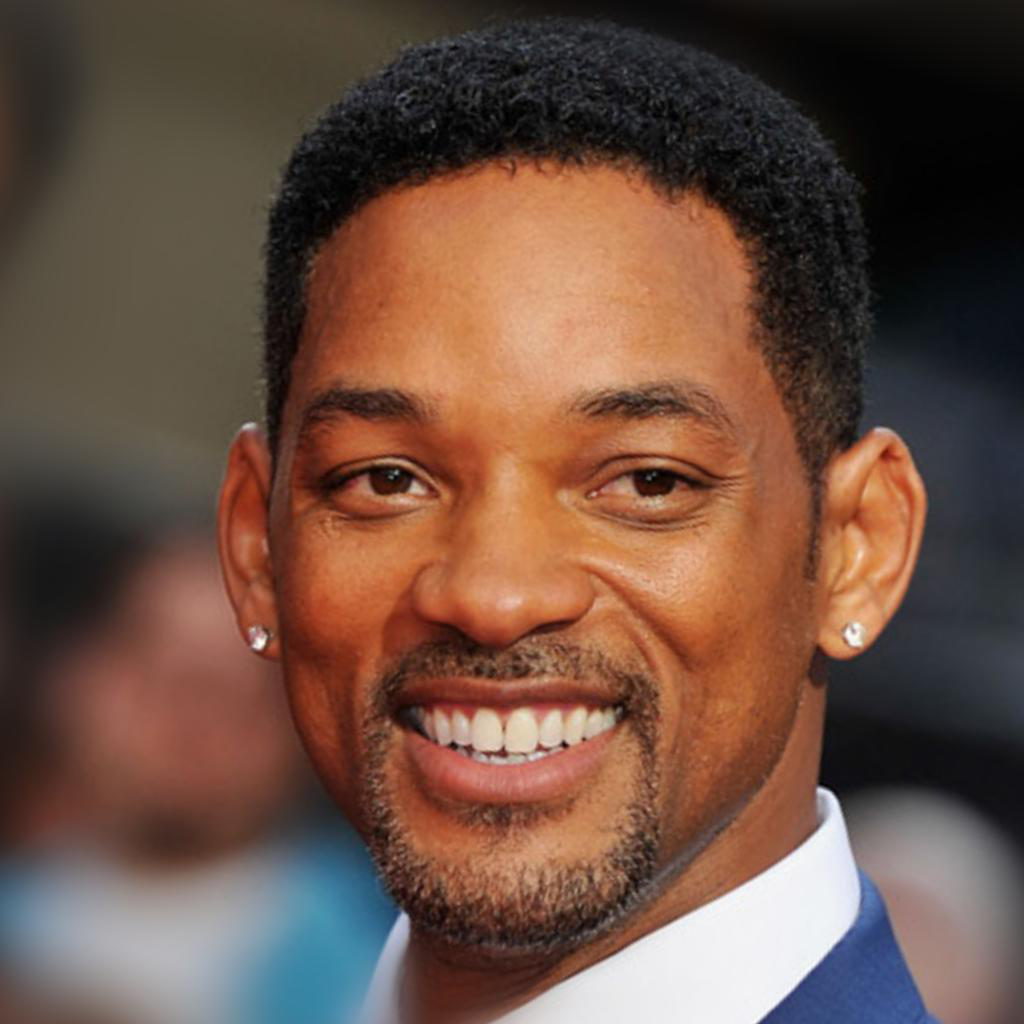

In [61]:
#@title Upload Image
#@markdown **Make sure your image is in square shape.**

from google.colab import files
from IPython.display import display

ff = files.upload()
image_name = list(ff.keys())[0]
img = Image.open(image_name)
image_name = image_name.replace(' ', '_')
min_v = min(img.size)
img = img.resize((min_v, min_v))
img.save(image_name)
display(img)

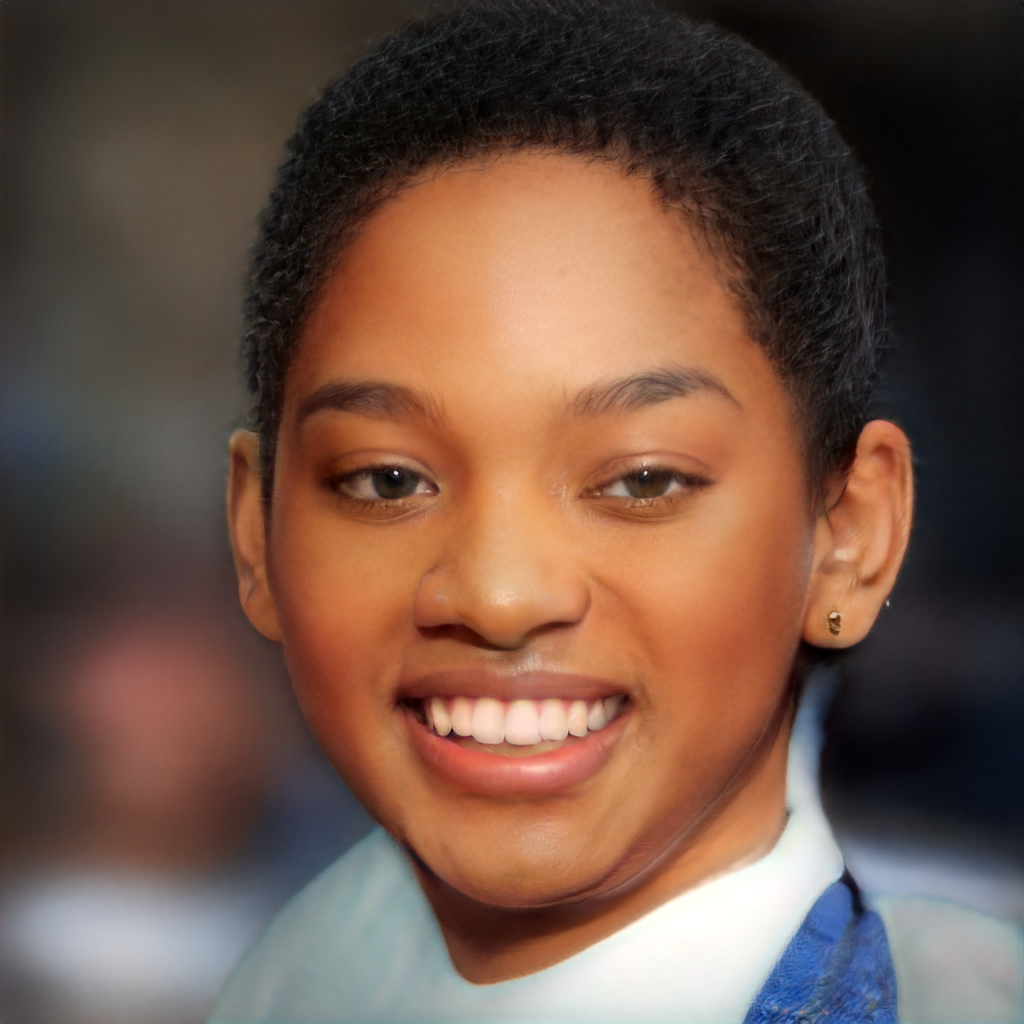

In [62]:
#@title Run

import os
import json

import torch
import numpy as np
from IPython.display import HTML

import models


mode = 'classical'  #@param ['classical', 'flexible', 'stylegan2']
mode = {
  'classical': 'anycost-ffhq-config-f',
  'flexible': 'anycost-ffhq-config-f-flexible',
  'stylegan2': 'stylegan2-ffhq-config-f',
}[mode]

target_resolution = "256"  #@param ["128", "256", "512", "1024"]
channel = "1.0"  #@param ['0.25', '0.5', '0.75', '1.0']

smile = 0  #@param {type:"slider", min:-1, max:1, step:0.01}
young = 1  #@param {type:"slider", min:-1, max:1, step:0.01}
wavy_hair = 0  #@param {type:"slider", min:-1, max:1, step:0.01}
gray_hair = 0  #@param {type:"slider", min:-1, max:1, step:0.01}
blond_hair = 0  #@param {type:"slider", min:-1, max:1, step:0.01}
glasses = 0  #@param {type:"slider", min:-1, max:1, step:0.01}
mustache = 0  #@param {type:"slider", min:-1, max:1, step:0.01}

#@markdown ### Other adjustable properties
prop_name = '18_Heavy_Makeup'  #@param ['00_5_o_Clock_Shadow', '01_Arched_Eyebrows', '02_Attractive', '03_Bags_Under_Eyes', '04_Bald', '05_Bangs', '06_Big_Lips', '07_Big_Nose', '08_Black_Hair', '10_Blurry', '11_Brown_Hair', '12_Bushy_Eyebrows', '13_Chubby', '14_Double_Chin', '16_Goatee', '18_Heavy_Makeup', '19_High_Cheekbones', '20_Male', '21_Mouth_Slightly_Open', '23_Narrow_Eyes', '24_No_Beard', '25_Oval_Face', '26_Pale_Skin', '27_Pointy_Nose', '28_Receding_Hairline', '29_Rosy_Cheeks', '30_Sideburns', '32_Straight_Hair', '34_Wearing_Earrings', '35_Wearing_Hat', '36_Wearing_Lipstick', '37_Wearing_Necklace', '38_Wearing_Necktie']
value = 1  #@param {type:"slider", min:-1, max:1, step:0.01}
other_props[prop_name] = value

direction_map = {
  '31_Smiling': smile,
  '39_Young': young,
  '33_Wavy_Hair': wavy_hair,
  '17_Gray_Hair': gray_hair,
  '09_Blond_Hair': blond_hair,
  '15_Eyeglasses': glasses,
  '22_Mustache': mustache,
}

# Intialize the generator and latent directions.
generator = models.get_pretrained('generator', mode).to('cuda').eval()
boundaries = models.get_pretrained('boundary', mode)
direction_dict = {k: v.view(1, 1, -1) for k, v in boundaries.items()}

# Generate the latent code of the uploaded image.
img_latent_path = os.path.splitext(image_name)[0] + '.npy'
if not os.path.exists(img_latent_path):
  %run tools/project.py --config {mode} {image_name}
img_latent_code = torch.from_numpy(np.load(img_latent_path)).view(1, -1, 512)

# Edit the latent code.
n_style_to_change = 12
ratio = 1.5
merged_map = {**direction_map, **other_props}
for d_name, d_val in merged_map.items():
  img_latent_code[:, :n_style_to_change] = \
    img_latent_code[:, :n_style_to_change] \
    + d_val * direction_dict[d_name] * ratio

# Generate the image.
with torch.no_grad():
  out = generator(
    styles=img_latent_code.to('cuda'),
    noise=None,
    randomize_noise=False,
    input_is_style=True
  )

print(json.dumps(merged_map, indent=2))
img = tensor_to_image(out[0].clamp(-1, 1))
display(img)
